# Learning in predictive coding network implemented in Nengo

Supplementary code for the paper
<br>
Sergey Sukhov and Bulat Batuev "Toy models of predictive coding for dynamic spiking neural networks".

Synchronization of two oscillators implemented in neuronal ensembles through learning. In line with Predictive coding concept, two oscillators are connected through auxiliary 'error' neuronal population. Feedforward and feedback connections ensure forward error propagation and back propagation of the prediction.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import nengo

## Construct network

In [2]:
model = nengo.Network()

tau_synapse = 0.1
omega = 8
tau_synapse2 = 0.1
omega2 = 14

with model:
    # auxiliary control of the frequency of master oscillator
    freq = nengo.Ensemble(n_neurons=50, dimensions=1)
    stim_freq = nengo.Node(1)
    nengo.Connection(stim_freq, freq)

    osc = nengo.Ensemble(n_neurons=500, dimensions=3, radius=1.5) # master oscillator
    osc2 = nengo.Ensemble(n_neurons=500, dimensions=3, radius=1.5) # receiver oscillator
    err = nengo.Ensemble(n_neurons=500, dimensions=3, radius=1.5) # error unit

    def recurrent(x): # recurrent connections in the first layer
        return [-tau_synapse*x[2]*omega*x[1]+x[0], tau_synapse*x[2]*omega*x[0]+x[1]]
    
    def recurrent2(x): # recurrent connections in the second layer
        return [-tau_synapse*x[2]*omega2*x[1]+x[0], tau_synapse*x[2]*omega2*x[0]+x[1]]
    
    nengo.Connection(osc, osc[:2], function=recurrent, synapse=tau_synapse) 
    
    def stim_func(t): # auxiliary function to kick-start oscillations
        if t < 0.1:
            return 1, 0
        else:
            return 0, 0
        
    stim = nengo.Node(stim_func)
    nengo.Connection(stim, osc[:2])
    nengo.Connection(freq, osc[2]) 
    
    nengo.Connection(osc2, osc2[:2], function=recurrent2, synapse=tau_synapse)
    nengo.Connection(osc, err, transform=-1) # feedback connection
    nengo.Connection(osc2, err)
    a = nengo.Connection(err, osc2, learning_rule_type=nengo.PES()) # trainable feedforward connection carrying error signal
    nengo.Connection(err, a.learning_rule)

## Add probes

In [3]:
with model:
    osc_probe = nengo.Probe(osc, synapse=0.01)
    error_probe = nengo.Probe(err, synapse=0.01)
    osc2_probe = nengo.Probe(osc2, synapse=0.01)

## Run the model

In [4]:
# Create simulator
with nengo.Simulator(model) as sim:
    # Run it for several seconds
    sim.run(15)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

## Plot the results

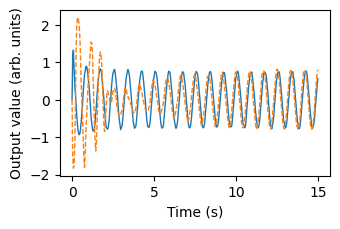

In [5]:
# Plot the decoded output of the ensemble
n = 40 # plot every n-th point
x = sim.trange()[::n]
y1 = sim.data[osc_probe][:,0][::n]
y2 = sim.data[osc2_probe][:,0][::n]

width = 3.487
height = width / 1.618

fig = plt.figure(figsize=(width,height))
plt.plot(x, y1, label="Master oscillator", linewidth=1)
plt.plot(x, y2, label="Receiver oscillator", linewidth=1, linestyle='dashed')
plt.xlabel("Time (s)", fontsize=10)
plt.ylabel("Output value (arb. units)", fontsize=10)
#plt.legend()

# save the figure if necessary
plt.savefig('Learning.svg', bbox_inches='tight')

In [8]:
# save data for further use
# import pickle

# data = {'time': sim.trange(),
#         'osc_output': sim.data[osc_probe].squeeze(),
#         'err_output': sim.data[error_probe].squeeze(),
#         'osc2_output': sim.data[osc2_probe].squeeze()}

# with open('PhaseSync.data', 'wb') as f:
#         pickle.dump(data, f)

# load previously save data
# with open('PhaseSync.data', 'rb') as f:
#         data = pickle.load(f)